In [29]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from astropy.table import Table
from desitarget.targetmask import desi_mask

%matplotlib inline

In [21]:
datapath = "/global/cscratch1/sd/forero/testfiber/dark_large/old_fiber_output/"
tiles = glob.glob(datapath+"*.fits")
tilefile = tiles[100]
fx = fits.open(tilefile)
print(fx.info())
print('\nFIBERASSIGN columns:')
print(fx['FIBERASSIGN'].data.dtype.names)
print('\nPOTENTIAL columns:')
print(fx['POTENTIAL'].data.dtype.names)
print('\nGFA columns:')
print(fx['GFA'].data.dtype.names)
fx.close()

Filename: /global/cscratch1/sd/forero/testfiber/dark_large/old_fiber_output/tile_23629.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  FIBERASSIGN    1 BinTableHDU    225   5000R x 108C   [J, J, I, J, K, K, K, K, D, D, E, E, 8A, J, E, E, E, 3A, I, J, J, J, J, 4A, E, E, 5E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, I, I, E, E, E, E, E, E, I, I, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, E, E, E, E, E, E, E, L, E, E, E, E, E, E, L, 1A, D, K, J, J]   
  2  POTENTIAL     1 BinTableHDU     15   46781R x 3C   [K, J, J]   
  3  SKYETC        1 BinTableHDU     37   20R x 14C   [J, J, I, J, K, K, K, K, D, D, E, E, 8A, J]   
  4  TARGETS       1 BinTableHDU    201   5000R x 96C   [K, J, J, 8A, J, 4A, D, D, E, E, 5E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, I, I, E, E, E, E, E, E, I, I, I, E, E, E, E, E, E, E, E, E, E, E, E, E, 

In [36]:


assigned = Table.read(tilefile, 'FIBERASSIGN')
gfa = Table.read(tilefile, 'GFA')
skyetc = Table.read(tilefile, 'SKYETC')


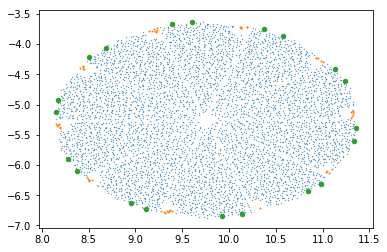

In [26]:
plt.scatter(assigned['TARGET_RA'], assigned['TARGET_DEC'], s=0.1)
plt.scatter(gfa['RA'], gfa['DEC'], s=1.0)
plt.scatter(skyetc['RA'], skyetc['DEC'], s=20.0)

In [86]:
def count_targets(tilefile):
    sky_mask = desi_mask.SKY
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
             'STD_FAINT', 'STD_FAINT_BEST',
             'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]


    assigned = Table.read(tilefile, 'FIBERASSIGN')
    potential = Table.read(tilefile, 'POTENTIAL')

    nassigned = len(assigned)-np.count_nonzero(assigned['TARGETID']<0)
    nstd = np.count_nonzero(assigned['DESI_TARGET'] & std_mask)
    nsky = np.count_nonzero(assigned['DESI_TARGET'] & sky_mask)
    npotential = len(potential)

    nscience = nassigned - nstd - nsky
    return {'RA':assigned['TARGET_RA'].mean(),
            'DEC':assigned['TARGET_DEC'].mean(),
            'npotential':npotential, 'nscience':nscience, 'nstd':nstd, 'nsky':nsky}

In [101]:
n_tiles = len(tiles)
n_tiles = 500
count_all = {}
for i in range(n_tiles):
    count_all[i] = count_targets(tiles[i])

In [102]:
all_sky = np.ones(n_tiles)
all_std = np.ones(n_tiles)
all_avail = np.ones(n_tiles)
all_science = np.ones(n_tiles)
all_ra = np.ones(n_tiles)
all_dec = np.ones(n_tiles)

for i in range(n_tiles):
    all_sky[i] = count_all[i]['nsky']
    all_std[i] = count_all[i]['nstd']
    all_avail[i] = count_all[i]['npotential']
    all_science[i] = count_all[i]['nscience']
    all_ra[i] = count_all[i]['RA']
    all_dec[i] = count_all[i]['DEC']

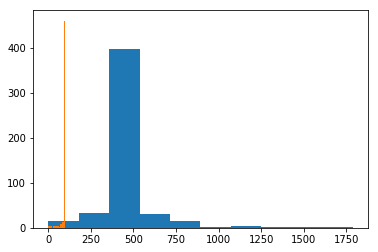

In [103]:
_ = plt.hist(all_sky)
_ = plt.hist(all_std)

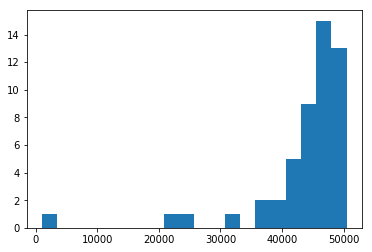

In [95]:
_ = plt.hist(all_avail, bins=20)

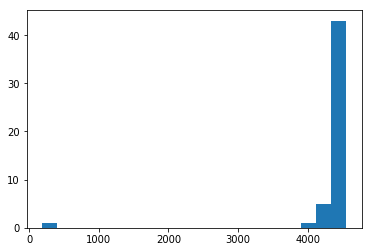

In [96]:
_ = plt.hist(all_science, bins=20)

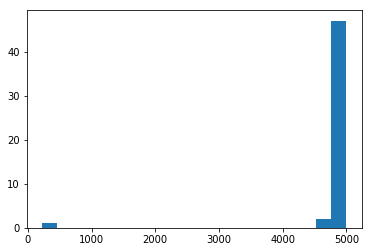

In [97]:
_ = plt.hist(all_science+all_sky+all_std, bins=20)

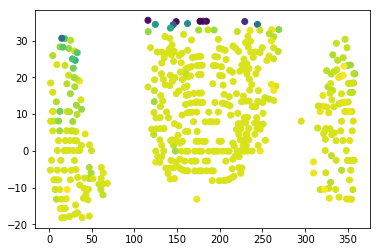

In [108]:
plt.scatter(all_ra, all_dec, c=all_science)

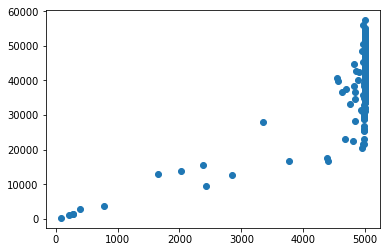

In [114]:
plt.scatter(all_science+all_sky+all_std, all_avail)